In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import xgboost as xgb
from sklearn.utils import resample
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, classification_report

### Funções XGBoost

In [3]:
# XGBoost Normal
def XGBoost(df):
    # Dividir em treino e teste
    X = df.drop('diagnostico', axis=1)
    y = df['diagnostico']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # Penaliza erros na classe minoritária
    scale_pos_weight = sum(y == 0) / sum(y == 1)

    params_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3,4,5],
        'min_child_weight': [2, 3, 4],
        'subsample': [0.6, 0.8, 1],
        'colsample_bytree': [0.5, 0.7]
    }

    classifier = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_classifier = GridSearchCV(classifier, params_grid, scoring='accuracy', cv=cv)
    grid_classifier.fit(X_val, y_val)
    
    best_parameters = grid_classifier.best_params_

    model = xgb.XGBClassifier(**best_parameters)

    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, pred)
    
    print(test_accuracy)    
    print(classification_report(y_test,pred))
    print(confusion_matrix(y_test, pred))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Sem Sepse', 'Com Sepse'], yticklabels=['Sem Sepse', 'Com Sepse'])
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()

In [4]:
# XGBoost com OverSampling
def XGBoost_Over(df):
    # Dividir em treino e teste
    X = df.drop('diagnostico', axis=1)
    y = df['diagnostico']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    X_train = pd.concat([X_train, y_train], axis=1)
    
    not_diagnostico = X_train[X_train.diagnostico==0]
    diagnostico = X_train[X_train.diagnostico==1]
    
    diagnostico_upsampled = resample(diagnostico, replace=True, n_samples=len(not_diagnostico), random_state=42)
    
    upsampled = pd.concat([not_diagnostico, diagnostico_upsampled])
    
    y_train = upsampled.diagnostico
    X_train = upsampled.drop('diagnostico', axis=1)

    scale_pos_weight = sum(y == 0) / sum(y == 1)

    params_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 4, 5],
        'min_child_weight': [2, 3, 4],
        'subsample': [0.6, 0.8, 1],
        'colsample_bytree': [0.5, 0.7]
    }

    classifier = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_classifier = GridSearchCV(classifier, params_grid, scoring='accuracy', cv=cv)
    grid_classifier.fit(X_val, y_val)
    
    best_parameters = grid_classifier.best_params_

    model = xgb.XGBClassifier(**best_parameters)

    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, pred)
    
    print(test_accuracy)    
    print(classification_report(y_test, pred))
    print(confusion_matrix(y_test, pred))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Sem Sepse', 'Com Sepse'], yticklabels=['Sem Sepse', 'Com Sepse'])
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()

### Sem Tratar Missing

In [ ]:
df_final = pd.read_csv('df_final.csv')

In [ ]:
XGBoost(df_final)

In [ ]:
XGBoost_Over(df_final)

### Valores Normais

In [ ]:
df_normal = pd.read_csv('df_normal.csv')

In [ ]:
XGBoost(df_normal)

In [ ]:
XGBoost_Over(df_normal)

### KNN

In [ ]:
df_knn = pd.read_csv('df_knn.csv')

In [ ]:
XGBoost(df_knn)

In [ ]:
XGBoost_Over(df_knn)

### Media

In [ ]:
df_media = pd.read_csv('df_media.csv')

In [ ]:
XGBoost(df_media)

In [ ]:
XGBoost_Over(df_media)

### Mediana

In [ ]:
df_mediana = pd.read_csv('df_mediana.csv')

In [ ]:
XGBoost(df_mediana)

In [ ]:
XGBoost_Over(df_mediana)

### Moda

In [ ]:
df_moda = pd.read_csv('df_moda.csv')

In [ ]:
XGBoost(df_moda)

In [ ]:
XGBoost_Over(df_moda)

### Regressão

In [5]:
df_regressao = pd.read_csv('df_regressao.csv')

0.9960761440161197
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     18720
         1.0       0.89      0.53      0.67       139

    accuracy                           1.00     18859
   macro avg       0.94      0.77      0.83     18859
weighted avg       1.00      1.00      1.00     18859

[[18711     9]
 [   65    74]]


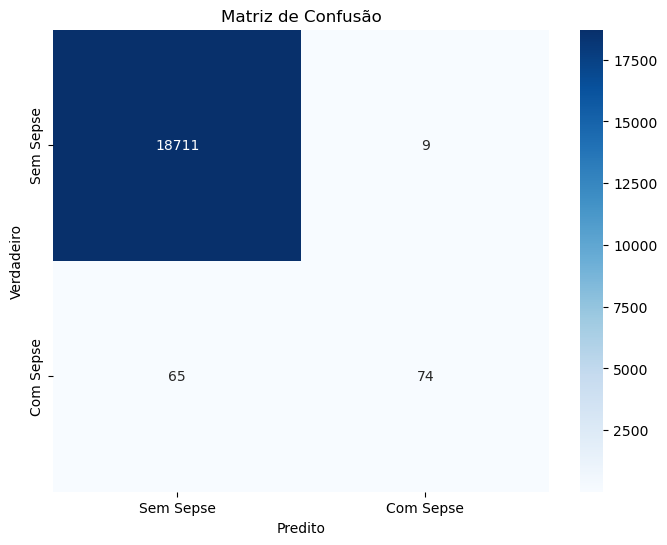

In [6]:
XGBoost(df_regressao)

0.9961291690969829
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     18720
         1.0       0.75      0.72      0.73       139

    accuracy                           1.00     18859
   macro avg       0.87      0.86      0.87     18859
weighted avg       1.00      1.00      1.00     18859

[[18686    34]
 [   39   100]]


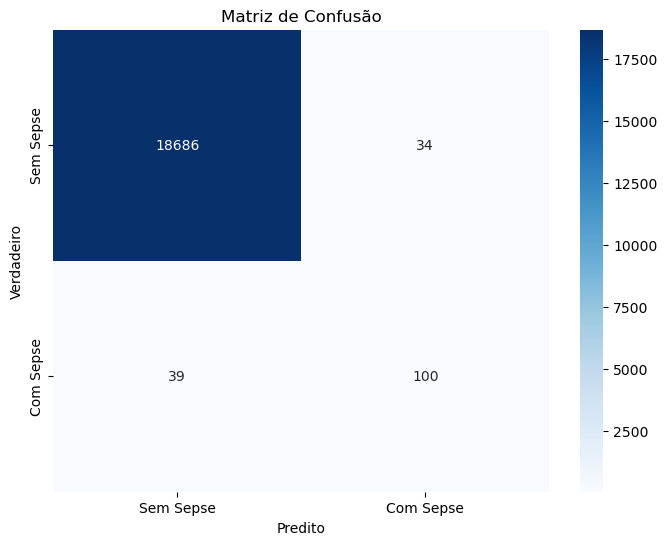

In [7]:
XGBoost_Over(df_regressao)